# Einfaches Transportproblem

Wir implementieren hier ein einfaches Transportproblem.

Eine Menge  $\mathcal B$ von Produktionsstätten und eine Menge $\mathcal C$ von Kunden ist gegeben. 
Die Produktionsstätte $i\in\mathcal B$ kann während der 
Produktionsperiode $a_i$kg *Frosted Sugar Flakes* herstellen. Der Kunde $j\in\mathcal C$ 
möchte in dieser Zeit die Menge $d_j$ (wieder in kg) abnehmen. Die Produktionsstätten
sind unterschiedlich effizient. Es kostet daher $b_i$€ um ein Kilogramm *Frosted Sugar Flakes*
in der Produktionsstätte $i\in\mathcal B$ herzustellen. Der Transport von $i\in\mathcal B$
pro Kilogramm zum Kunden $j\in\mathcal C$ schlägt mit $c_{ij}$€ zu Buche.
Welche Produktionsstätte soll nun welchen Kunden mit wie viel Produkt beliefern, so dass die Gesamtkosten
möglichst gering sind?

Als lineares Programm:
$$
\begin{array}{lll}
\min & \sum_{i\in\mathcal B}\sum_{j\in\mathcal C}b_ix_{ij}+c_{ij}x_{ij} &\\
\text{unter} & \sum_{j\in\mathcal C}x_{ij}\leq a_i&\quad\text{für alle }i\in\mathcal B\\
&\sum_{i\in\mathcal B}x_{ij}=d_j&\quad\text{für alle }j\in\mathcal C
\end{array}
$$

Wenn Sie in Google Colab arbeiten, dann verwenden Sie die nächste Zelle so wie sie ist. Wenn Sie auf dem eigenen Rechner arbeiten und mip bereits installiert haben, dann löschen Sie die nächste Zelle oder kommentieren Sie per Raute den Installationsbefehl.

In [1]:
# für google colab
!pip install mip  # Löschen / Auskommentieren, wenn Sie mip bereits installiert haben.

Wiederum müssen wir das Paket <code>mip</code> auch importieren, um es zu verwenden. Wir importieren noch ein paar mehr Pakete, und zwar:
* <code>math</code>: stellt mathematische Funktionen wie zB die Wurzel zur Verfügung (gehört zum Kern von Python und muss nicht installiert werden);
* <code>random</code>: Erzeugung von Zufallszahlen (gehört zum Kern von Python und muss nicht installiert werden);
* <code>numpy</code>: das Standardpaket für wissenschaftliches Rechnen; hier brauchen wir <code>numpy</code> nur hinter den Kulissen, um die Visualisierung ein wenig leichter zu machen
* <code>matplotlib</code>: das Standardpaket für Plots

Wenn Sie Google Colab verwenden, dann sind die Pakete <code>numpy</code> und <code>matplotlib</code> vorinstalliert.

In [2]:
import mip
import random  ## Standard-Bibliothek zur Erzeugung von Zufallszahlen
import math
### Wir werden die Daten plotten und müssen dafür matplotlib einbinden
import matplotlib.pyplot as plt # Abkürzung plt
import numpy as np # Abkürzung np

## Erzeugung einer Zufallsinstanz

Für das Transportproblem erzeugen wir eine zufällige Instanz. Dazu platzieren wir Produktionsstätten und Kunden zufällig in der Ebene. Als Transportkosten nehmen wir dann den gewöhnlichen Abstand in der Ebene. Die folgende Funktion, deren Funktionsweise Sie nicht im Detail verstehen müssen, erzeugt die Zufallsinstanz. Sie gibt vier Variablen zurück:
* <code>factories</code>: eine Liste mit den Positionen im $\mathbb R^2$ der Produktionsstätten;
* <code>customers</code>: eine Liste mit den Positionen im $\mathbb R^2$ der Kunden;
* <code>supplies</code>: eine Liste mit dem Angebot der jeweiligen Produktionsstätte (Index entspricht dem Index in <code>factories</code>); und
* <code>demands</code>: eine Liste mit der jeweiligen Nachfrage eines Kunden.

Wir rufen die Funktion <code>rnd_instance</code> gleich auf, um eine Zufallsinstanz zu erzeuge.

In [3]:
def rnd_instance(num_factories,num_customers):
    factories=[(random.random(),random.random()) for _ in range(num_factories)]
    customers=[(random.random(),random.random()) for _ in range(num_customers)]
    demands=[0.5+random.random() for _ in range(num_customers)]  
    total_demand=sum(demands)
    supply_factor=total_demand/num_factories
    ### wir stellen sicher, dass die Nachfrage abgedeckt werden kann
    insufficient_supply=True
    while insufficient_supply:
        supplies=[0.3*supply_factor+random.random()*1.1*supply_factor for _ in range(num_factories)]
        if sum(supplies)>=total_demand:
            insufficient_supply=False
    return factories,customers,supplies,demands

num_factories=3
num_customers=10
B,C,a,d=rnd_instance(num_factories=num_factories,num_customers=num_customers)

Schauen wir doch einmal hinein in die Instanz. Zunächst in <code>B</code>, die Liste der Produktionsstätten:

In [4]:
B

[(0.2641845535382612, 0.5387849647275759),
 (0.1300793808320465, 0.49354787702288405),
 (0.3522381633025484, 0.07741945051870303)]

Aha, wir sehen drei Produktionsstätten und ihre jeweiligen Positionen in der Ebene. Gucken wir auch in <code>C</code>, die Liste der Kunden:

In [5]:
C

[(0.8355345757930434, 0.07368612939877717),
 (0.014069265879523285, 0.7962542931265697),
 (0.1382130091471816, 0.6170945824721362),
 (0.8324272685396684, 0.5803577966784107),
 (0.38313515033070855, 0.8884800208100996),
 (0.17826003203688612, 0.17690166712356725),
 (0.7602274504664918, 0.9136945874089863),
 (0.7777062654826008, 0.16027715648918894),
 (0.8587930529307164, 0.7932789237644837),
 (0.6468753714154554, 0.5084519012405255)]

Ein wenig länger: es gibt 10 Kunden, jeweils mit 2-dimensionalen Koordinaten. Schließlich gucken wir auch in das Angebot <code>a</code> und die Nachfrage <code>d</code>:

In [6]:
print("Angebot: {}".format(a))
print("Nachfrage: {}".format(d))

Angebot: [5.9743785731562955, 2.1036626222040136, 5.480622032510086]
Nachfrage: [1.2037486493303886, 1.286133408146552, 1.1935524404227218, 1.4612857229947491, 1.3905475183315215, 1.328299863282023, 1.4180760194317639, 1.4093872285759574, 1.415850926938966, 1.2166668462402788]


Die Transportkosten sollen euklidisch sein, also einfach direkt dem Abstand entsprechen. Dazu brauchen wir den euklidischen Abstand.

In [7]:
def distance(factory,customer):
    px,py=factory  # unpack 2d coordinates of factory
    qx,qy=customer # unpack 2d coordinates of customer 
    return math.sqrt((px-qx)**2+(py-qy)**2) # **2 is the square function, math.sqrt is the square root

# ausprobieren
distance( (1,1), (2,3) )

2.23606797749979

## Das lineare Programm

Stellen wir das LP auf. Als Variablen benötigen wir nur die Transportvariablen $x_{ij}$. Diese wollen wir in einer 2-dimensionalen Liste <code>x</code>, also einer Liste von Listen, speichern. Dazu nutzen wir die Listensyntax von Python. Machen wir es uns erst einmal einfach, und nehmen an, wir wollten 100 nicht-negative Variablen zu einem linearen Programm hinzufügen. Dann geht das so:



In [8]:
toy_model=mip.Model()

z= [ toy_model.add_var() for i in range(100) ]

Was passiert hier? Die Funktion <code>range(100)</code> erzeugt einfach eine Liste mit den Zahlen [0,1,2,...,99]. Der Code <code>for i in range(100)</code> iteriert dann über diese Liste und befüllt sukzessive die Variable <code>i</code> mit den Zahlen von 0,...,99. Jedes Mal, wenn <code>i</code> eine neue Zahl zugewiesen bekommt, wird dann <code>toy_model.add_var()</code> aufgerufen. Dabei wird eine Variable des LPs erzeugt und zurück geliefert. Die Syntax mit den eckigen Klammern <code>[...]</code> erzeugt dann eine Liste, in der alle diese LP-Variablen drin stehen. 

Schauen wir mal, was in <code>z</code> drin steckt. Damit das nicht so lang wird, gucken wir uns nur die ersten 10 Einträge an. Das geht so:

In [9]:
z[:10]

Aha, lauter Variablen. Wenn man jetzt genauer auf den Code oben guckt, dann stellt man fest, dass <code>i</code> eigentlich gar nicht mitspielt. Um zu signalisieren, dass die Laufvariable nicht wichtig ist, kann man sie als <code>_</code> bezeichnen, so wie hier:

In [10]:
z= [ toy_model.add_var() for _ in range(100) ]

Das ist exakt das gleiche wie oben. Nun gut. Die Variablen $x_{ij}$ in unserem Transportproblem haben zwei Indizes. Daher definieren wir eine Liste, deren Einträge Listen sind:

In [11]:
model=mip.Model()
x=[[model.add_var() for _ in range(num_customers)] for _ in range(num_factories)]

Schauen wir uns auch <code>x</code> an.

In [12]:
x

[[<mip.entities.Var at 0x7fba32523370>,

Man sieht: Eine äußere Liste, die drei Listen à 10 Einträge enthält. Wenn wir nun auf einen bestimmten Eintrag zugreifen wollen, können wir das so machen:

In [13]:
x[1][8]

Diese Syntax mit den Doppelklammern ist zugegebenermaßen ein wenig häßlich. (Mit <code>numpy</code> hat man eine etwas schönere Syntax, aber das führt jetzt zu weit.)

Als nächstes wollen wir die Bedingungen hinzufügen. Wir fangen damit an, dass keine Produktionsstätte mehr produziert, als sie kann. Oben im LP ist das eine Zeile. Tatsächlich aber haben wir eine Bedingung pro Produktionsstätte. Daher verwenden wir eine <code>for</code>-Schleife. Jede Bedingung selbst besteht aus einer Summe über die Transportvariablen, die zu der Produktionsstätte <code>i</code> gehören. Die Syntax sieht so aus:

In [14]:
for i in range(num_factories):
    model += mip.xsum( x[i][j] for j in range(num_customers) )<=a[i]

Das Innere <code>x[i][j] for j in range(num_customers)</code> lässt das <code>j</code> über alle Kunden iterieren. Die Funktion <code>mip.xsum</code> bildet dann die Summe. (Tatsächlich könnte man auch die eingebaute Funktion <code>sum</code> verwenden, aber <code>mip.xsum</code> soll schneller sein.)

Die Bedarfsbedingungen (zweite Bedingung im LP oben) ist nun einfach.

In [15]:
for j in range(num_customers):
    model +=mip.xsum(x[i][j] for i in range(num_factories))==d[j]

Die Zielfunktion besteht einfach aus den Transportkosten. Der Einfachheit halber lassen wir die Produktionskosten weg, bzw. nehmen an, dass die 
Produktionskosten in allen Produktionsstätten gleich sind. Die Kosten sind, wie gesagt euklidisch, dh, die Abstandsfunktion <code>distance</code> kommt zum Einsatz. Die Summe hat zwei Laufvariablen, <code>i</code> und <code>j</code>. Dementsprechend nutzen wir zwei <code>for</code>.

In [16]:
model.objective=mip.minimize(mip.xsum(x[i][j]*distance(B[i],C[j]) for i in range(num_factories) for j in range(num_customers)))

Schließlich starten wir die Optimierung. 

In [17]:
model.optimize()

Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming problem using Dual Simplex



<OptimizationStatus.OPTIMAL: 0>

Wir plotten das Ergebnis. Den Code können Sie getrost ignorieren.

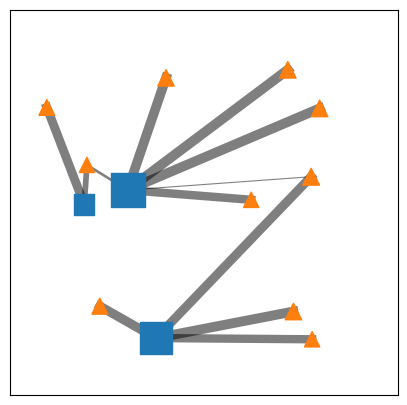

In [18]:
plt.figure(figsize=(5,5))
BB=np.array(B)
CC=np.array(C)
plt.scatter(BB[:,0],BB[:,1],s=np.array(a)*100,marker='s')
plt.scatter(CC[:,0],CC[:,1],s=np.array(d)*100,marker='^')
for i in range(num_factories):
    for j in range(num_customers):
        if x[i][j].x>0.0001:
            plt.plot([BB[i,0],CC[j,0]],[BB[i,1],CC[j,1]],'k',zorder=-1,alpha=0.5,linewidth=x[i][j].x*5)
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xticks([])
plt.yticks([])
plt.show()

Im Plot sind die Produktionsstätten als Quadrate, die Kunden als Dreiecke widergegeben. Die Größen (Durchmesser) spiegeln den Bedarf/die Nachfrage wider. Ebenso ist die Linienstärke der Verbindungen proportional zum Transport.